In [1]:
import pandas as pd
import numpy as np
import pymysql

In [10]:
conn = pymysql.connect(host = 'codeborn-bi-db.cvv1o1yrngie.ap-northeast-2.rds.amazonaws.com',
                        port = 3306,
                        user = 'butterfree',
                        password = '4hHl68aS8UbJ',
                        db = 'codeborn')

sql_courses = "SELECT course_id FROM courses\
                WHERE professor_id = 11"
courses_data = pd.read_sql_query(sql_courses, conn)

sql_assignments = "SELECT * FROM assignments"
assignments_data = pd.read_sql_query(sql_assignments, conn)

sql_submissions = "SELECT submission_id, assignment_id, student_id FROM submissions\
                    WHERE assignment_id != 1\
                        AND student_id != 11"
submissions_data = pd.read_sql_query(sql_submissions, conn)

sql_students = "SELECT * FROM students"
students_data = pd.read_sql_query(sql_students, conn)
submissions_data

/var/folders/vs/d7h80pg10h31n7bq9nk3bhxc0000gn/T/ipykernel_69789/2501003758.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  courses_data = pd.read_sql_query(sql_courses, conn)
/var/folders/vs/d7h80pg10h31n7bq9nk3bhxc0000gn/T/ipykernel_69789/2501003758.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  assignments_data = pd.read_sql_query(sql_assignments, conn)
/var/folders/vs/d7h80pg10h31n7bq9nk3bhxc0000gn/T/ipykernel_69789/2501003758.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  submissions_data = pd.read_sql_

,submission_id,assignment_id,student_id
0,2,2,1
1,17,2,22
2,18,2,22
3,23,2,13
4,24,2,13
...,...,...,...
21052,21363,41,212
21053,21364,41,193
21054,21365,41,195
21055,21366,41,195


In [3]:
# 1번 각 코스별로 제출 학생의 숫자와 숙제 평균 맞는 개수를 출력하시오
assignment_id = pd.DataFrame(assignments_data, columns=["course_id",  "assignment_id", "started_date", "ended_date"]) 
assignment_id = assignment_id[assignment_id.assignment_id != 1]

courses_assignment= pd.merge(courses_data, assignment_id, on='course_id', how='left')

join_data = pd.merge(courses_assignment, submissions_data, on='assignment_id', how= 'left') 
join_data_count =  join_data.groupby('course_id').agg({'assignment_id': 'nunique',
                                    'submission_id': 'count'
})
join_data_count.rename(columns = {'assignment_id':'assignment_count', 'submission_id':'submission_count'}, \
    inplace=True)
join_data_count

,assignment_count,submission_count
course_id,,
DSAA-2021,11,3568
DSAA-2022,7,3379
PY-2022S,11,14110


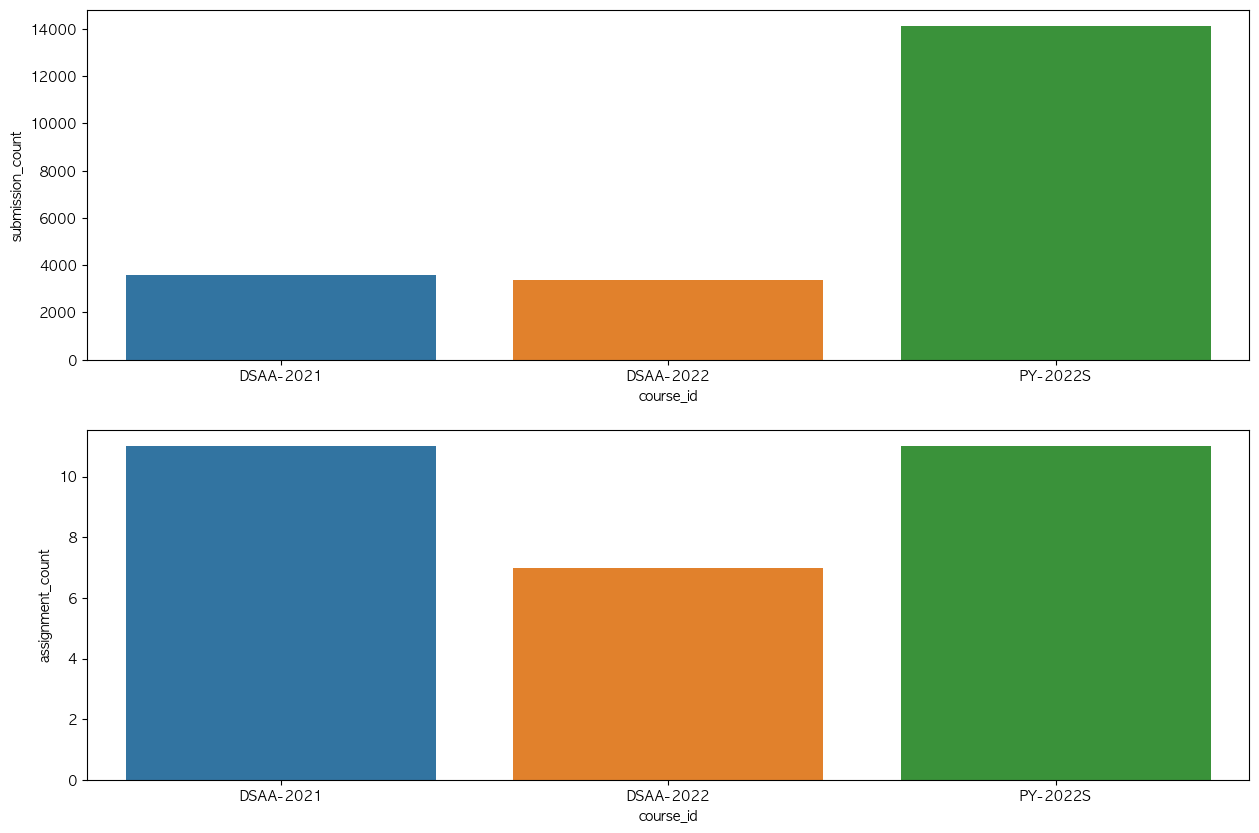

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

join_data_count = join_data_count.reset_index()
join_data_count
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
sns.barplot(x = "course_id", y = "submission_count", data = join_data_count, ax = ax[0])
sns.barplot(x = "course_id", y = "assignment_count", data = join_data_count, ax = ax[1])
plt.show()

In [7]:
# 2번 각 코스별, 숙제별로 숙제를 가장 빨리 제출한 학생의 아이디와 제출한 시간을 출력하시오

sql_submissions = "SELECT submission_id, assignment_id, student_id, submit_date FROM submissions\
                    WHERE assignment_id != 1\
                        AND student_id != 11"
submission_df = pd.read_sql_query(sql_submissions, conn)

submitdate_df = pd.merge(courses_assignment, submission_df, on='assignment_id', how= 'left') 
submitdate_df = submitdate_df[submitdate_df.started_date <= submitdate_df.submit_date]
submitdate_df = submitdate_df[submitdate_df.ended_date >= submitdate_df.submit_date]


min_submit_date = submitdate_df.groupby(['course_id','assignment_id'])['submit_date'].min()
student_id_with_min_submit_date = submitdate_df.loc[submitdate_df.groupby(['course_id','assignment_id'])['submit_date'].idxmin()]['student_id'].reset_index()
result = pd.concat([min_submit_date.reset_index(), student_id_with_min_submit_date], axis=1)
student_id_with_min_submit_date

/var/folders/vs/d7h80pg10h31n7bq9nk3bhxc0000gn/T/ipykernel_69789/4020943553.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  submission_df = pd.read_sql_query(sql_submissions, conn)


,index,student_id
0,43,16
1,983,15
2,1027,28
3,1250,12
4,1411,24
5,1427,21
6,1506,52
7,2300,42
8,3213,25
9,3446,30


In [40]:
# 3번 각 코스별, 숙제별로 학생들이 숙제를 제출한 횟수를 출력하시오
submission_id_df = pd.merge(courses_assignment, submission_df, on='assignment_id', how='left') 
submission_id_df = submission_id_df[submission_id_df.started_date <= submission_id_df.submit_date]
submission_id_df = submission_id_df[submission_id_df.ended_date >= submission_id_df.submit_date]

submit_count_df = submission_id_df.groupby(['course_id','assignment_id']).agg({
                            'submission_id': 'count'
                        })
submit_count_df

submission_id
course_id assignment_id               
DSAA-2021 2                        155
          3                         40
          6                        180
          8                        109
          10                        14
          11                        26
          13                       728
          14                       790
          16                       228
          18                       116
          22                         2
DSAA-2022 35                       392
          36                       119
          37                        90
          38                       265
          39                        84
          40                       538
          41                        67
PY-2022S  21                         7
          23                       735
          24                      1332
          25                      1326
          26                       775
          27                       435
          28                        10
          29                      1897
          30                      2074
          33                       677
          34                       804

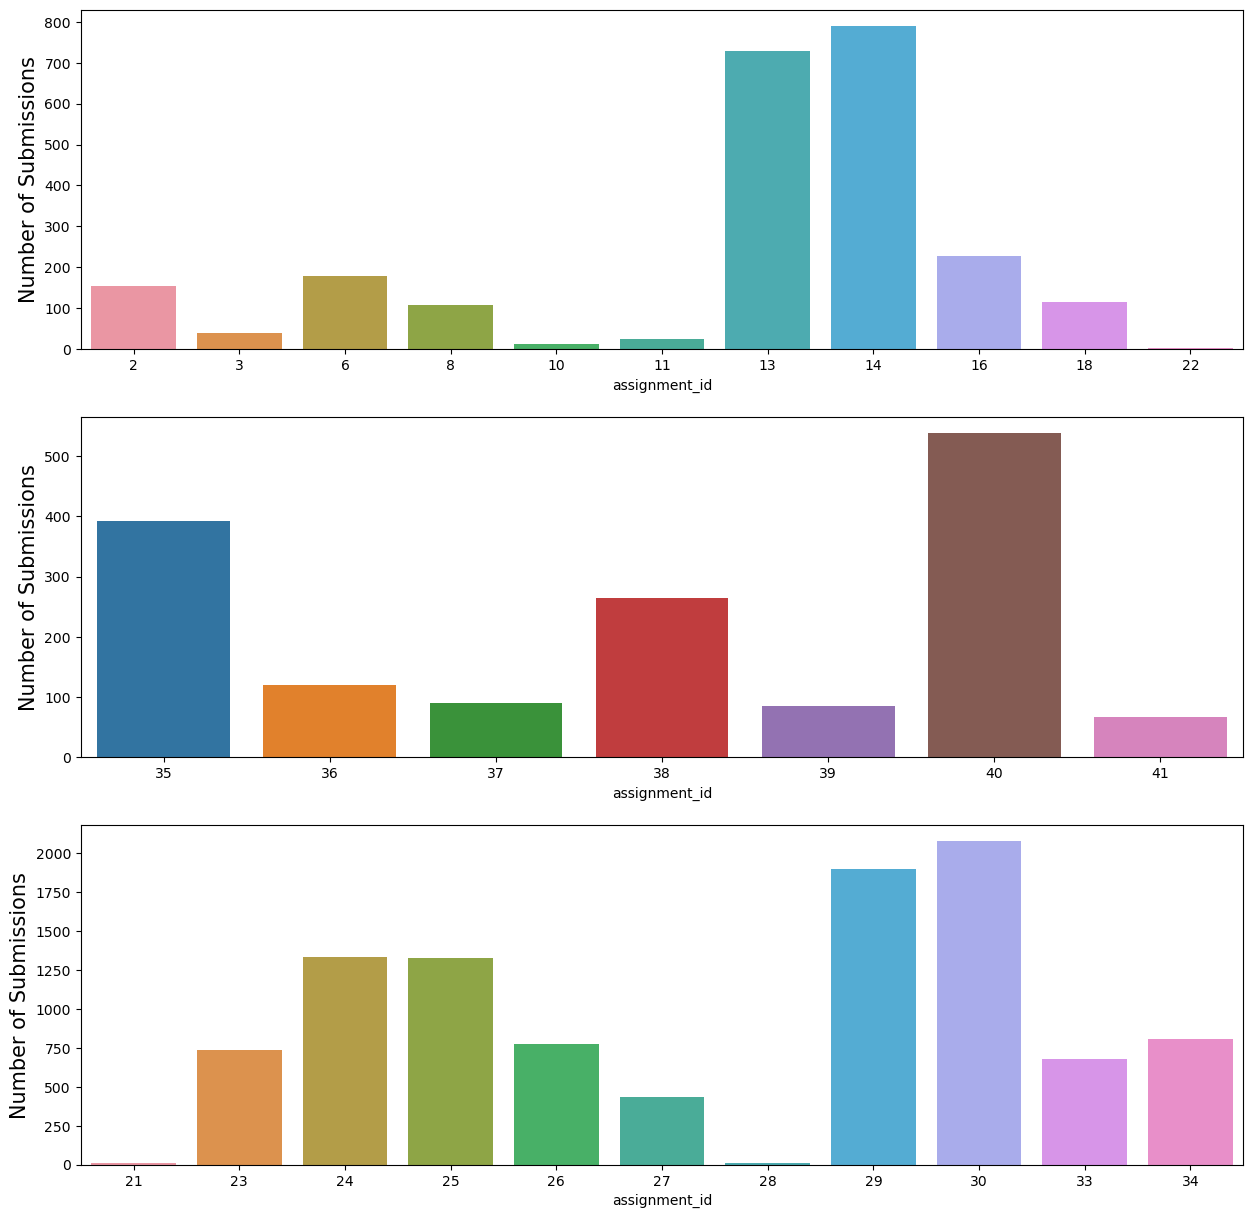

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
submit_count_df = submit_count_df.reset_index()
fig, ax = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "DSAA-2021"], ax = ax[0])
plt.ylabel('pH(0(very acidic) to 14(very basic))', fontsize=15)
sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "DSAA-2022"], ax = ax[1])
sns.barplot(x = "assignment_id", y = "submission_id", data=submit_count_df[submit_count_df['course_id'] == "PY-2022S"], ax = ax[2])
for i in range(3):
    ax[i].set_ylabel('Number of Submissions', fontsize=15)
plt.show()

In [9]:
#4번 각 코스별, 숙제별, 학생별로 처음 만점이 될 때까지의 제출 횟수를 출력하시오 
#단 만점이 아닌 경우에는 출력하지 않습니다.
submission_df= pd.DataFrame(submissions_data, columns= ["submission_id", "assignment_id", "student_id", "total_score"])
# courses_assignment = courses_assignment.drop(['started_date','ended_date'] , axis=1)
total_score_df = pd.merge(courses_assignment, submission_df, on = 'assignment_id', how='left')
total_score_df = total_score_df[total_score_df.total_score == 100]

# total_score_df 중복처리 ?
total_score_df = total_score_df.drop(["submission_id"],axis=1)
total_score_df = total_score_df.drop_duplicates()

#100점 여러개인것 고려/ 중복 처리는 ?

score_count = submission_df.groupby(["assignment_id","student_id"]).agg({
    "total_score": "count"
})
pd.merge(total_score_df, score_count, on= "student_id",how= 'right')



,course_id,assignment_id,started_date,ended_date,submission_id,student_id,total_score
0,DSAA-2021,2,2021-09-19,2021-09-25,2,1,NaN
1,DSAA-2021,2,2021-09-19,2021-09-25,17,22,NaN
2,DSAA-2021,2,2021-09-19,2021-09-25,18,22,NaN
3,DSAA-2021,2,2021-09-19,2021-09-25,23,13,NaN
4,DSAA-2021,2,2021-09-19,2021-09-25,24,13,NaN
...,...,...,...,...,...,...,...
21052,PY-2022S,34,2022-05-29,2022-06-13,17978,62,NaN
21053,PY-2022S,34,2022-05-29,2022-06-13,17979,62,NaN
21054,PY-2022S,34,2022-05-29,2022-06-13,17980,95,NaN
21055,PY-2022S,34,2022-05-29,2022-06-13,17981,67,NaN


cumcount 찾아보기

In [11]:
# 8번 각 코스별, 각 숙제별로 학생들이 처음 제출한 시간과 마지막으로 제출한 시간을 출력하시오
submitdate_df.groupby(['course_id','assignment_id']).agg({
                            'submit_date': [min,max]
                        })


SyntaxError: invalid syntax (1439178945.py, line 4)